In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import zipfile
import io

In [209]:
df = pd.read_csv('euromillions_Fusion.csv',sep=';', encoding='ISO-8859-1')

In [210]:
df_ligth = df[['etoile_1','etoile_2']]

In [211]:
df_ligth.head()

,etoile_1,etoile_2
0,7,12
1,12,8
2,9,12
3,3,1
4,8,3


In [212]:
for column in df_ligth.columns:
    counts = df_ligth[column].value_counts()
#    print(f"\nDistribution of {column}:\n{counts}")

## Create Data with a windows

In [213]:
# frequency of a number in the last window rows
def count_frequency(dataframe, windows):
    df_ = dataframe.copy()
    # for col in ['boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5']:
    #     df_[f'freq_{col}'] = df_.apply(lambda row: sum(df_[['boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5']].iloc[max(0, row.name - windows):row.name].values.flatten() == row[col]), axis=1)
    for col in ['etoile_1', 'etoile_2']:
        df_[f'freq_{col}'] = df_.apply(lambda row: sum(df_[['etoile_1', 'etoile_2']].iloc[max(0, row.name - windows):row.name].values.flatten() == row[col]), axis=1)
    return df_

In [346]:
windows = 15

In [347]:
df_ligth = df_ligth[::-1].reset_index(drop=True)

In [348]:
print(df_ligth.head(2))
print(df_ligth.tail(2))

   etoile_1  etoile_2
0         7        12
1        12         8
     etoile_1  etoile_2
762        10         2
763         2        12


In [349]:
df_extend = count_frequency(df_ligth, windows = windows)

In [350]:
df_extend.shape

(764, 4)

In [351]:
df_extend.tail(5)

,etoile_1,etoile_2,freq_etoile_1,freq_etoile_2
759,4,11,0,3
760,11,9,4,5
761,4,11,1,4
762,10,2,2,3
763,2,12,3,0


In [352]:
# def quadra_dif(data):
#   df_ = data.copy()
#   columns_to_diff = ['boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5']
#   for i in range(0, df_.shape[0]):
#     df_['sum_diff_r2'] = ((df_[columns_to_diff].diff(axis=1) ** 2).sum(axis=1)).astype(int)
#   return df_

In [353]:
# df_extend = quadra_dif(df_extend)

In [354]:
# How long the number didn't not appear
def no_star(data):
  df_ = data.copy()
  for num in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
    mask = ((df_['etoile_1'] == num) | (df_['etoile_2'] == num))
    df_[f'no_s{num}'] = (~mask).groupby((mask).cumsum()).cumsum()
    # df_[f'no_{num}'] = df_[f'no_{num}'].shift(fill_value=0).astype(int)
  return df_

# def no_ball(data):
#   df_ = data.copy()
#   for num in range(51):
#     mask = ((df_['boule_1'] == num) | (df_['boule_2'] == num) | (df_['boule_3'] == num) | (df_['boule_4'] == num) | (df_['boule_5'] == num))
#     df_[f'no_b{num}'] = (~mask).groupby((mask).cumsum()).cumsum()
#   return df_

In [355]:
df_extend = no_star(df_extend)

In [356]:
df_extend.head(5)

,etoile_1,etoile_2,freq_etoile_1,freq_etoile_2,no_s1,no_s2,no_s3,no_s4,no_s5,no_s6,no_s7,no_s8,no_s9,no_s10,no_s11,no_s12
0,7,12,0,0,1,1,1,1,1,1,0,1,1,1,1,0
1,12,8,1,0,2,2,2,2,2,2,1,0,2,2,2,0
2,9,12,0,2,3,3,3,3,3,3,2,1,0,3,3,0
3,3,1,0,0,0,4,0,4,4,4,3,2,1,4,4,1
4,8,3,1,1,1,5,0,5,5,5,4,0,2,5,5,2


In [357]:
# Function to create sequences for X and y
def create_sequences(data, length):
    X,Y = [],[]
    for i in range(len(data)-length):
        X.append(data.iloc[i:i+length, 0:data.shape[1]].values)
        Y.append(data.iloc[i+length, 0:2])

    return np.array(X),np.array(Y)

# Define the sequence length
rows_windows = windows

# Create sequences for X and y
X, y = create_sequences(df_extend, rows_windows)

# Print the shapes of X and y
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (749, 15, 16)
y shape: (749, 2)


In [358]:
y[-4]

array([11,  9])

In [359]:
# Scaled data because StandardScaler expected <= 2 dim
from sklearn.model_selection import train_test_split

X_scaled = (X - np.mean(X, axis=0))/np.std(X, axis=0)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.05, shuffle=False)

In [360]:
print('X_train:', X_train.shape, 'X_test:', X_test.shape)
print('y_train:', y_train.shape, 'y_test:', y_test.shape)

X_train: (711, 15, 16) X_test: (38, 15, 16)
y_train: (711, 2) y_test: (38, 2)


##Model: TSLM

In [361]:
# LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Define the model
def my_LSTM(units, window_length, nb_label_feature, nb_label, dropout):

    model = Sequential()

    # We add two layers of LSTM
    model.add(LSTM(units=units, input_shape=(window_length, nb_label_feature), return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units=units, return_sequences=False))
    # Output layer
    model.add(Dense(units=nb_label))

    return model

In [362]:
units = 1024
window_length = rows_windows
nb_feature = X_train.shape[2]
nb_label = y.shape[1]
DROPOUT = 0.2
BATCHSIZE = 64
EPOCHS = 1000
OPTIMIZER  = Adam(learning_rate=0.0002)#'rmsprop'#
# ACTIVATION = 'softmax'
LOSS = 'mean_squared_error'

In [363]:
model = my_LSTM(units, window_length, nb_feature, nb_label, DROPOUT)
model.compile(loss = LOSS, optimizer = OPTIMIZER, metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 15, 1024)          4263936   
                                                                 
 dropout_21 (Dropout)        (None, 15, 1024)          0         
                                                                 
 lstm_29 (LSTM)              (None, 15, 1024)          8392704   
                                                                 
 dropout_22 (Dropout)        (None, 15, 1024)          0         
                                                                 
 lstm_30 (LSTM)              (None, 15, 1024)          8392704   
                                                                 
 dropout_23 (Dropout)        (None, 15, 1024)          0         
                                                                 
 lstm_31 (LSTM)              (None, 1024)             

In [364]:
# # Define early stopping

# early_stop = EarlyStopping(monitor='val_loss', patience=500, restore_best_weights=True)

In [365]:
# history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCHSIZE, validation_data=(X_test, y_test), callbacks=[early_stop, my_lr_scheduler], verbose=1)
# model.save('test'+'.h5')

In [366]:
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCHSIZE)
model.save(f'test_valid_test_star_{units}_{BATCHSIZE}_{window_length}_{DROPOUT}'+'.h5')

Epoch 1/1000
12/12 [==============================] - 8s 64ms/step - loss: 48.4323 - accuracy: 0.4838
Epoch 2/1000
12/12 [==============================] - 1s 59ms/step - loss: 16.3650 - accuracy: 0.4951
Epoch 3/1000
12/12 [==============================] - 1s 60ms/step - loss: 12.2408 - accuracy: 0.4838
Epoch 4/1000
12/12 [==============================] - 1s 59ms/step - loss: 12.2809 - accuracy: 0.4852
Epoch 5/1000
12/12 [==============================] - 1s 59ms/step - loss: 12.0881 - accuracy: 0.5021
Epoch 6/1000
12/12 [==============================] - 1s 59ms/step - loss: 12.0964 - accuracy: 0.5288
Epoch 7/1000
12/12 [==============================] - 1s 60ms/step - loss: 11.9973 - accuracy: 0.4993
Epoch 8/1000
12/12 [==============================] - 1s 61ms/step - loss: 12.2740 - accuracy: 0.4909
Epoch 9/1000
12/12 [==============================] - 1s 59ms/step - loss: 11.8972 - accuracy: 0.5063
Epoch 10/1000
12/12 [==============================] - 1s 59ms/step - loss: 11.807

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


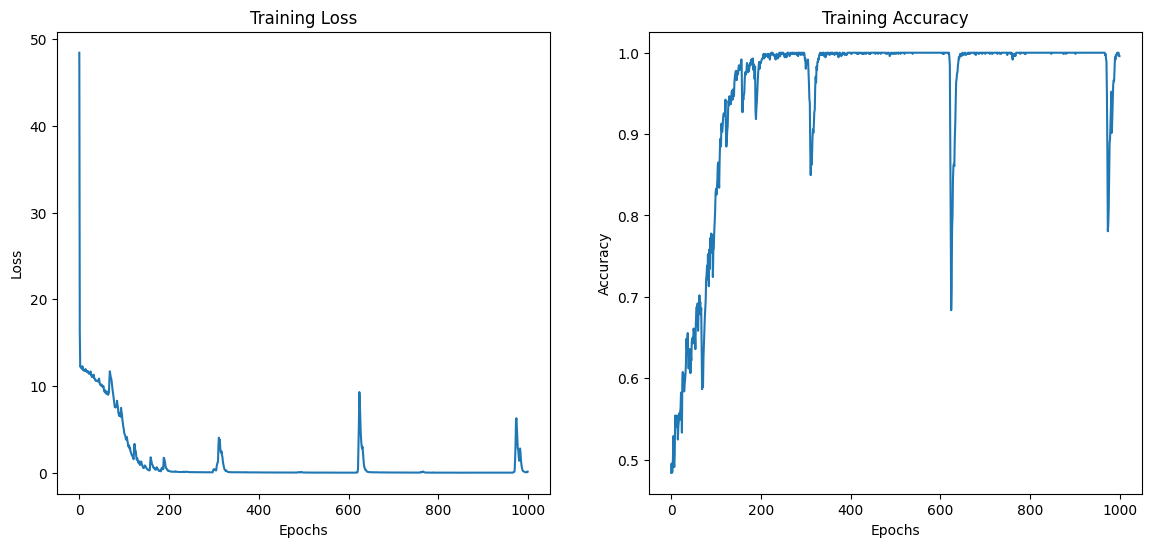

In [367]:
# Plotting the training and validation loss
# plt.figure(figsize=(10, 8))
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs[0].plot(history.history['loss'], label='Loss')
# axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')

# plot 2
axs[1].plot(history.history['accuracy'], label='accuracy')
axs[1].set_title('Training Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')

plt.show()

In [368]:
predictions = model.predict(X_test)

2/2 [==============================] - 1s 10ms/step


In [369]:
# for idx in range(0, y_test.shape[0]):
#   predicted = np.round(predictions[idx]).astype(int)
#   print(f'row {idx}:----------------------------------------------------------','\ny_pred', predicted, '\ny_test', y_test[idx], '\nvalid ',np.isin(np.round(predictions[idx,:5]).astype(int), y_test[idx,:5]), np.isin(np.round(predictions[idx,-2:]).astype(int), y_test[idx,-2:]))

In [370]:
def post_traitement(predic):
    predicted = []
    for idx in range(y_test.shape[0]):
        array = np.clip(np.round(predic[idx]).astype(int), 1, 12)

        # unique_values, counts = np.unique(array[:5], return_counts=True)
        # duplicates_exist = any(counts > 1)
        unique_star, counts_s = np.unique(array[-2:], return_counts=True)
        duplicates_star = any(counts_s > 1)

        # if duplicates_exist:
        #     duplicate_indices = np.where(np.isin(array[:5], unique_values[counts > 1]))[0]
        #     val0 = (predic[idx][duplicate_indices[0]] - array[duplicate_indices[0]])**2
        #     val1 = (predic[idx][duplicate_indices[1]] - array[duplicate_indices[1]])**2

        #     # Update array based on minimizing squared differences
        #     if val0 < val1:
        #         array[duplicate_indices[1]] += 1 if (predic[idx][1] > array[duplicate_indices[1]] and ((array[duplicate_indices[1]] + 1) not in array[:5])) else -1
        #     else:
        #         array[duplicate_indices[0]] += 1 if (predic[idx][0] > array[duplicate_indices[0]] and ((array[duplicate_indices[0]] + 1) not in array[:5])) else -1

        if duplicates_star:
            star_indices = np.where(np.isin(array[-2:], unique_star[counts_s > 1]))[0]
            star0 = (predic[idx][star_indices[0]] - array[star_indices[0]])**2
            star1 = (predic[idx][star_indices[1]] - array[star_indices[1]])**2

            # Update array based on minimizing squared differences
            if star0 < star1:
                array[star_indices[1]] += 1 if predic[idx][1] > array[star_indices[1]] else -1
            else:
                array[star_indices[0]] += 1 if predic[idx][0] > array[star_indices[0]] else -1

        #Printing results for test
        print(f'row {idx}:----------------------------------------------------------','\ny_pred', array, '\ny_test', y_test[idx], '\nvalid ', np.isin(array[-2:], y_test[idx,-2:]))
        # Append the processed array to the predicted list
        predicted.append(array)

    return predicted

In [371]:
predictions[7]

array([3.478437 , 6.6651306], dtype=float32)

In [372]:
y_train[-1]

array([10,  8])

In [373]:
prediction_test = post_traitement(predictions)

row 0:---------------------------------------------------------- 
y_pred [10  9] 
y_test [9 5] 
valid  [False  True]
row 1:---------------------------------------------------------- 
y_pred [2 6] 
y_test [6 9] 
valid  [False  True]
row 2:---------------------------------------------------------- 
y_pred [5 4] 
y_test [9 5] 
valid  [ True False]
row 3:---------------------------------------------------------- 
y_pred [11  5] 
y_test [3 8] 
valid  [False False]
row 4:---------------------------------------------------------- 
y_pred [9 1] 
y_test [3 5] 
valid  [False False]
row 5:---------------------------------------------------------- 
y_pred [2 8] 
y_test [10  2] 
valid  [ True False]
row 6:---------------------------------------------------------- 
y_pred [2 3] 
y_test [4 7] 
valid  [False False]
row 7:---------------------------------------------------------- 
y_pred [3 7] 
y_test [4 9] 
valid  [False False]
row 8:---------------------------------------------------------- 
y_pred [